# Interatomic force field (IFF) optimization for W-based metal alloys

## Input data preparation

Author: Lukas Vlcek

Start Date: 2018-04-22

1. Read parameters from a pickle, and plot fpair, edens, and embed using library spline functions
2. Fit splines with given knots to another curve, which can be another spline defined by knots and coefficients.
2. Convert splines to a representation more suited for optimization

In [1]:
import sys
import os
import re
import numpy as np
from scipy.optimize import fmin
import scipy.interpolate as inter
import pickle
%matplotlib inline
import matplotlib.pyplot as plt
import copy

In [2]:
%load_ext autoreload
%autoreload 2

In [4]:
# statmech library setup
sys.path.append('../../statmechlib')
from statmechlib.preprocessing import select_nodes, to_param_dict, to_param_list, insert_zero_params, rescale_manybody_params
from statmechlib.preprocessing import Trajectory, find_index, pair_dist_cutoff, universal_eos, downselect
from statmechlib.forcefields import utot_EAM_per_atom, utot_EAM_per_box, udif_print, u_core, u_components
from statmechlib.read_write import params_to_pickle
from statmechlib.forcefields import f_embed, f_dens, f_spline3

In [5]:
working = '../data/working'

In [52]:
# read list of param dicts
params_file = 'params_optimal'
with open(os.path.join(working, params_file + '.pickle'), 'rb') as fi:
    param_list_all = pickle.load(fi)  

In [53]:
stats_file = 'stats_all_samples' # 'stats_samples'
with open(os.path.join(working, stats_file+'.pickle'), 'rb') as fi:
    stats_all = pickle.load(fi)

In [72]:
param_list = param_list_all[0:1] + param_list_all[-2:]

In [73]:
S = []
for pars in param_list:
    pair_knots = pars['hyperparams']['pair']
    edens_knots = pars['hyperparams']['edens']
    stats = downselect(stats_all, pair_knots, edens_knots)
    S.append(1.0/u_components(pars, stats['relax'])['edens'][0])
    print(1/S[-1], S[-1])

(4.1226644289869725, 0.24256158055670846)
(2.8587092686587425, 0.34980821973169129)
(2.6361190410578592, 0.37934553956967959)


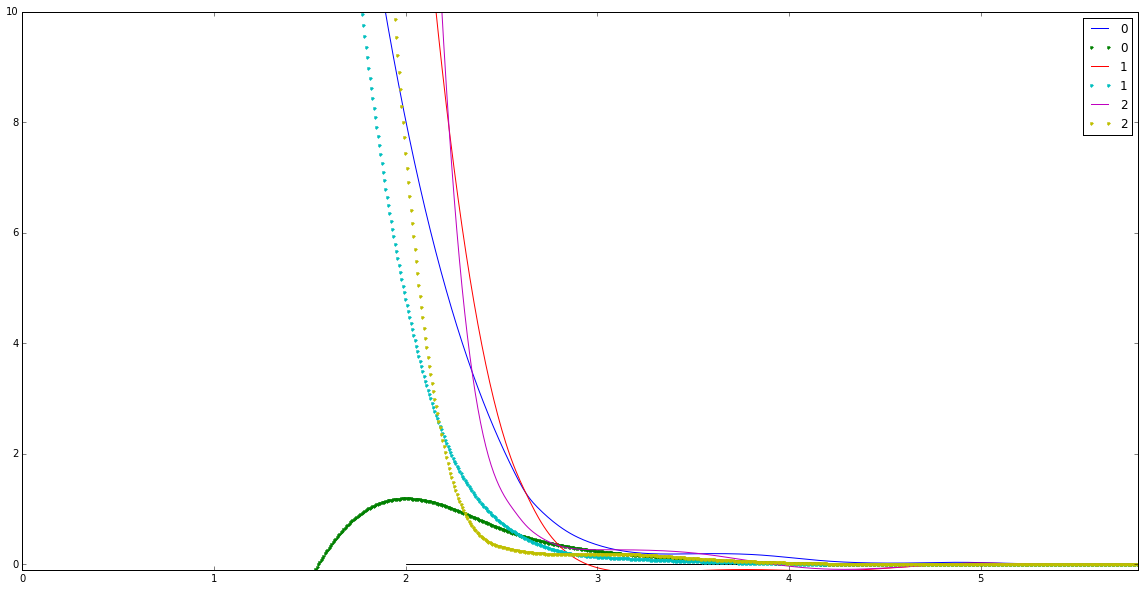

In [77]:
plt.figure(figsize=(20,10))
for i, params in enumerate(param_list):
    knots_pair = params['hyperparams']['pair']
    coeff_pair = params['params']['pair']
    knots_edens = params['hyperparams']['edens']
    coeff_edens = params['params']['edens']
    embed = params['params']['embed']
    
    rs = np.linspace(1, 5.82, 701)
    y_pair = [f_spline3(r, coeff_pair, knots_pair) for r in rs]
    y_edens = [f_spline3(r, coeff_edens, knots_edens) for r in rs]
    
#    plt.scatter(params['hyperparams']['pair'], np.zeros(len(params['hyperparams']['pair'])))
    if i == -1:
        plt.vlines(params['hyperparams']['pair'], -10, 10)
        plt.vlines(params['hyperparams']['edens'], -10, 10, colors='m')
    
    plt.plot(rs, y_pair, '-', label=str(i))
    plt.plot(rs, y_edens, '.', label=str(i))
    
    plt.xlim(0.0, 5.82)
    plt.ylim(-0.1,10.0)
    plt.hlines(xmin=2.0, xmax=6.0, y=0.0)

plt.legend()

(0, array([-5.946454, -0.049477]))
(0, 1.8722845236273526, 0.24256158055670846)
(1, [-5.94255002, -0.00452753307])
(1, 1.7832341413113038, 0.34980821973169129)
(2, [-6.67485922, -0.0102376651])
(2, 2.1095327937217041, 0.37934553956967959)


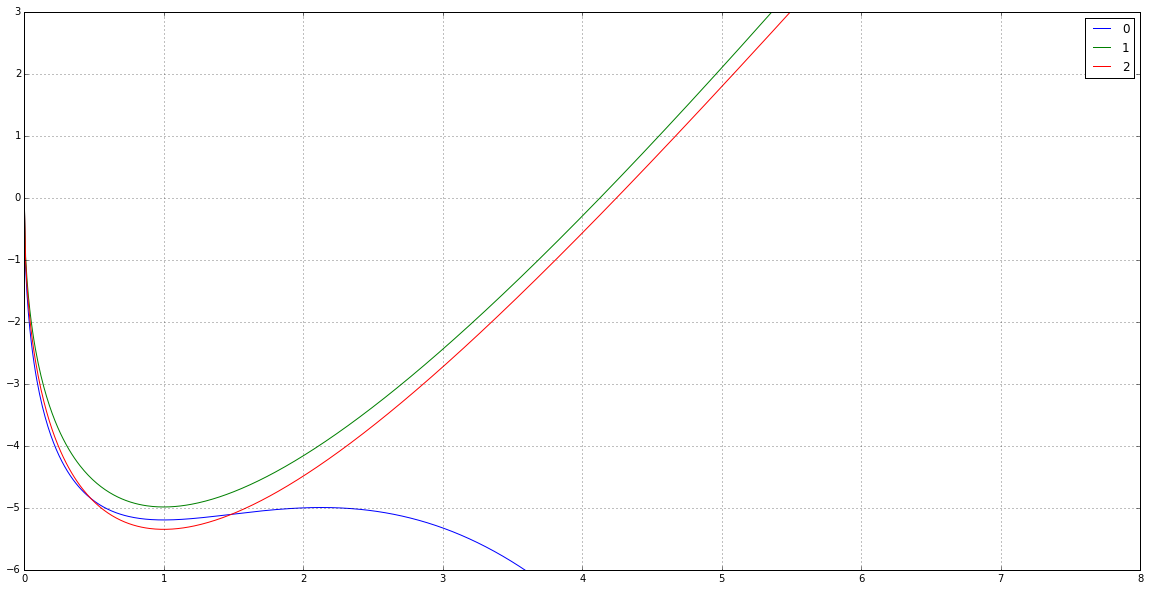

In [75]:
#S = [1./4.12265151, 1./8.44551209, 1./12.71800096]
plt.figure(figsize=(20,10))
for i, params in enumerate(param_list):
    embed = params['params']['embed']
    rs = np.linspace(0, 10, 1001)
    #F = [f_embed(r, embed) for r in rs]
    print(i, embed)
    
    A = params['params']['embed'][0]
    B = params['params']['embed'][1]
    
    C = (-A/2.0/np.sqrt(S[i]) - 2*B/S[i]**2)*S[i]
    
    print(i, C, S[i])
    
    F = [f_embed(r/S[i], [A, B]) + r/S[i]*C for r in rs]
    
    plt.plot(rs, F, '-', label=str(i))
    
    #F = [f_embed(r/0.223232, embed) for r in rs]
#     A = [-5.946454, -0.049477]
#     Fx = lambda d, a: a[0]*d**0.5 + a[1]*d**2 #+ 1.848055990*d
#     d = np.linspace(0., 8., 101)
#     plt.plot(d, [Fx(x/0.223232, A) for x in d])
    #plt.plot(rs, F, '-', label=str(i))

    plt.xlim(0, 8)
    plt.ylim(-6,3.0)
    plt.grid(True)
    
#     plt.hlines(xmin=2.0, xmax=6.0, y=0.0)

plt.legend()

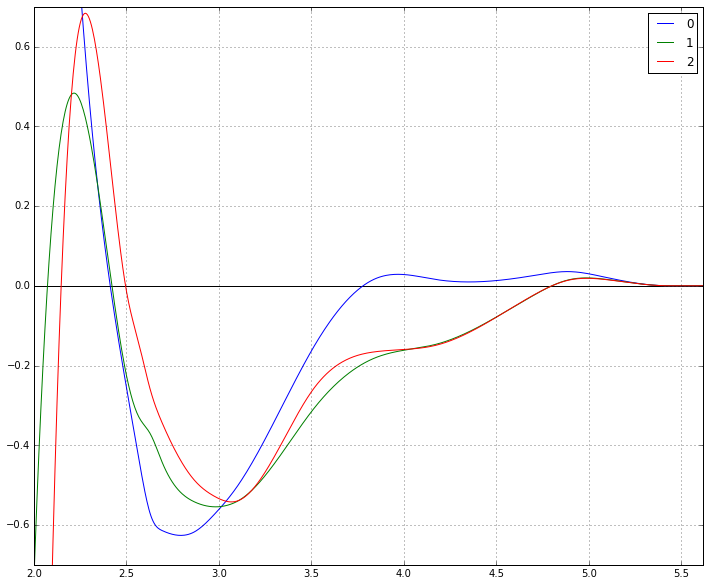

In [76]:
#S = [1./4.12265151, 1./8.44551209, 1./12.71800096]

plt.figure(figsize=(12,10))
for i, params in enumerate(param_list):
    params = param_list[i]
    knots_pair = params['hyperparams']['pair']
    coeff_pair = params['params']['pair']
    knots_edens = params['hyperparams']['edens']
    coeff_edens = params['params']['edens']
    embed = params['params']['embed']
    
    A = params['params']['embed'][0]
    B = params['params']['embed'][1]
    
    C = (-A/2.0/np.sqrt(S[i]) - 2*B/S[i]**2)*S[i]
    
    rs = np.linspace(2, 5.82, 701)
    y_pair = np.array([f_spline3(r, coeff_pair, knots_pair) for r in rs])
    y_edens = np.array([f_spline3(r, coeff_edens, knots_edens) for r in rs])
    
#    plt.scatter(params['hyperparams']['pair'], np.zeros(len(params['hyperparams']['pair'])))
    if i == -1:
        plt.scatter(params['hyperparams']['pair'], np.zeros(len(params['hyperparams']['pair'])))
        plt.vlines(params['hyperparams']['pair'], -10, 10)
        plt.vlines(params['hyperparams']['edens'], -10, 10, colors='m')
    
    plt.plot(rs, y_pair - 2.*C*y_edens, '-', label=str(i))
    #plt.plot(rs, y_pair, '-', label=str(i))

    #plt.plot(rs, y_edens, '.', label=str(i))
    
    plt.xlim(2.0, 5.62)
    plt.ylim(-0.7,0.7)
    plt.hlines(xmin=2.0, xmax=6.0, y=0.0)

plt.legend()
plt.grid(True)

In [66]:
params = param_list[-4]
knots_pair = list(params['hyperparams']['pair'])
coeff_pair = list(params['params']['pair'])
knots_edens = params['hyperparams']['edens']
coeff_edens = params['params']['edens']
print(knots_pair)
print(coeff_pair)
print(knots_edens)
print(coeff_edens)

[2.2200000000000002, 2.46, 2.5648974999999998, 2.6297950000000001, 2.6946924999999999, 2.8663175000000001, 2.9730449999999999, 3.0797724999999998, 3.5164724999999999, 3.8464450000000001, 4.1764175000000003, 4.7008450000000002, 4.8952999999999998, 5.0897550000000003, 5.3429525, 5.4016950000000001, 5.4604375000000003, 5.54, 5.5800000000000001, 5.6200000000000001]
[4525.61445, 107.488634, -15.2604631, 8.88626493, 10.7120352, 46.1310765, 6.70641338, -7.14000617, -2.02174483, 1.9897676, -1.35491449, -0.812592118, 1.99278451, -0.484145757, -0.0478673818, -1.46201396, 1.19810233, -0.00736954413, -0.00388205423, -0.00512566656]
[2.2200000000000002, 2.5, 2.8663175000000001, 3.1000000000000001, 3.5, 4.6200000000000001]
[3987.36133, 85.8053818, 31.7983469, -1.52861585, -1.77508182, 0.207405945]


In [12]:
#rs = np.linspace(2.2, 5.66, 347)
rs = np.linspace(2.2, 5.62, 343)
#print(rs[-1])

y_pair = [f_spline3(r, coeff_pair, knots_pair) for r in rs]

# y_pair += [0.0 for _ in np.linspace(5.11, 5.20, 10)]
# y_pair += [-0.03 for _ in np.linspace(5.21, 5.56, 36)]
# y_pair += [0.0 for _ in np.linspace(5.561, 5.66, 10)]

# #rs = np.linspace(2.2, 5.66, 347)
# rs = np.linspace(2.0, 4.62, 263)

# #print(len(rs), len(y_pair))
# y_edens = [f_spline3(r, coeff_edens, knots_edens) for r in rs]

#loss = lambda p, x, y, k: sum([(yi - f_spline3(xi, p, k))**2 for xi, yi in zip(x, y)])

def loss(p, x, y, k):
    ls = sum([(yi - f_spline3(xi, p, k))**2 for xi, yi in zip(x, y)])
    print(ls)
    return ls

In [19]:
y_pair


[15.490246798027005,
 14.739272325675362,
 14.00131770518918,
 13.289171282590079,
 12.604837523859644,
 11.947624924969524,
 11.316841981891272,
 10.711797190596595,
 10.131799047057008,
 9.5761560472441936,
 9.0441766871296956,
 8.5351694626852144,
 8.048442869882269,
 7.5833054046925454,
 7.1390655630875912,
 6.7150318410391066,
 6.3105127345186034,
 5.9248167394977571,
 5.5572523519481649,
 5.2071280678414382,
 4.8737523831491671,
 4.5564337938430128,
 4.2544807958945441,
 3.9672018852753865,
 3.6939055579571551,
 3.4339003099114542,
 3.1864946371099236,
 2.9511032084661224,
 2.7275653846616947,
 2.515826699320268,
 2.3158326860654412,
 2.1275288785208026,
 1.9508608103099974,
 1.785774015056603,
 1.6322140263842755,
 1.4901263779165994,
 1.359456603277188,
 1.2401376763971612,
 1.1318271409186025,
 1.0339143775865871,
 0.94577766125792095,
 0.8667952667894312,
 0.79634546903791303,
 0.73380654319513994,
 0.67859808352593376,
 0.63029510703820435,
 0.5885091682497503,
 0.5528518216

In [20]:
import copy

# knots_pair_new = copy.deepcopy(knots_pair)
# knots_pair_new[:] = knots_pair_new[0:5] + [2.74] + knots_pair_new[5:-2] + [5.66, 5.70, 5.78]

# coeff_pair_new = copy.deepcopy(coeff_pair)
# coeff_pair_new[:] = coeff_pair_new[0:5] + [0.0] + coeff_pair_new[5:-2] + [0.0, 0.0, 0.0]


knots_pair_new = copy.deepcopy(knots_pair)
knots_pair_new[:] = knots_pair_new[0:-4] + [5.18, 5.38, 5.58, 5.62]

coeff_pair_new = copy.deepcopy(coeff_pair)
#coeff_pair_new[:] = coeff_pair_new[0:-4] + [0.0, 0.0, 0.0, 0.0]
coeff_pair_new = [ -3.15188190e+03,   1.34941491e+02,   3.89509425e+01,
        -2.11375863e+01,   1.94935919e+01,   4.90884806e+01,
         6.70138768e+00,  -8.08659946e+00,  -1.78466166e+00,
         1.79415594e+00,  -1.38331952e+00,  -3.81312314e-01,
         1.38132444e+00,  -4.98167894e-01,  -4.06284764e-02,
        -6.19026091e-01,   6.03402041e-01]

print(knots_pair_new)
print(coeff_pair_new)

# knots_edens_new = copy.deepcopy(knots_edens)
# knots_edens_new[:] = [2.22] + knots_edens_new[:-1] + [4.62]

# coeff_edens_new = copy.deepcopy(coeff_edens)
# coeff_edens_new[:] = [0.0] + coeff_edens_new[:]

# print(knots_edens_new)
# print(coeff_edens_new)

[2.2200000000000002, 2.46, 2.5648974999999998, 2.6297950000000001, 2.6946924999999999, 2.8663175000000001, 2.9730449999999999, 3.0797724999999998, 3.5164724999999999, 3.8464450000000001, 4.1764175000000003, 4.7008450000000002, 4.8952999999999998, 5.18, 5.38, 5.58, 5.62]
[-3151.8819, 134.941491, 38.9509425, -21.1375863, 19.4935919, 49.0884806, 6.70138768, -8.08659946, -1.78466166, 1.79415594, -1.38331952, -0.381312314, 1.38132444, -0.498167894, -0.0406284764, -0.619026091, 0.603402041]


In [113]:
new_edens = fmin(loss, coeff_edens_new, args=(rs, y_edens, knots_edens_new), maxiter=100000, maxfun=100000, disp=0, full_output=1,ftol=1e-6)

print(coeff_edens_new)
print(new_edens)

4598.99848831
4598.99848836
4600.91155086
4543.64456733
4610.06062512
4668.52084102
4504.22480179
4485.82536943
4398.50745282
4471.86238564
4437.41150826
4388.41037544
4289.25987933
4289.25987939
4254.42382857
4116.55543296
4172.56626969
4102.19081252
3933.15269244
3976.71385811
3879.1495115
3657.32020496
3765.49814711
3612.22174153
3337.63518791
3440.32530933
3327.56722049
3081.8297054
3129.22539485
2985.53078069
2769.85122301
2828.50524287
2723.39111208
2703.47085849
2765.31380683
2866.25070604
3029.83674692
3197.14525842
2812.72866586
2991.78133071
2791.99521961
3016.26004126
2751.59784536
2775.69489282
2739.04860055
2971.82437411
2719.75404601
2703.90076606
2831.91450707
2718.9980003
2643.92998097
2591.40396768
2610.09754819
2744.21488365
2681.62020372
2611.31509034
2582.41484308
2552.09901006
2600.10433621
2494.75972761
2418.83022142
2407.82739231
2282.20976087
2364.88350061
2325.46841499
2320.11940635
2152.60794047
1985.43883974
2074.45110698
2006.77554959
1925.61158877
1737.8014

58.8842046401
58.0761898153
57.9070797898
57.2812030654
56.5497351099
55.0356583956
56.426663534
55.818283891
57.8376141369
56.0599310955
56.2822180814
54.909071038
55.9810557476
54.4704182391
55.3330685173
54.9646122797
55.9621954789
55.0273630587
54.6978972352
52.8290131913
51.9022225238
52.7606867898
55.2703653473
53.7607319778
53.2004738859
52.1476104414
52.1905545408
51.849936267
53.5185502561
50.2758108342
49.3506755126
52.0852569246
50.0440101968
50.7198031638
51.5547071104
51.3146264648
49.4500641713
49.2977762336
50.4366277023
48.4982925039
48.9356132812
51.0712246153
49.5671896433
48.5290485135
48.4371610723
49.3486181094
48.3447740554
49.1957504245
48.3578384232
47.4842419715
47.5175168596
47.2419818711
47.5866009028
48.2904184453
47.5745697967
47.4131196159
47.5349541509
46.8596164351
47.5359147703
47.6575558048
47.0605697876
47.0669510949
47.7983822123
47.0106811176
47.4719227948
47.0121609442
46.3112365732
45.9967666755
46.4883879808
46.9328619515
46.5968481939
47.3376212

KeyboardInterrupt: 

In [21]:
new_pair = fmin(loss, coeff_pair_new, args=(rs, y_pair, knots_pair_new), maxiter=100000, maxfun=100000, disp=0, full_output=1,ftol=1e-6)

print(coeff_pair_new)
print(new_pair)

10.1345085902
10.1299712578
11.587451249
11.3574434281
9.13539085759
11.7097565078
24.407979151
12.330306562
7.69158629103
8.30381757649
19.2319757177
11.3247926988
9.49850009556
98.8257372971
20.5025878563
9.51173202923
65.003460846
96.9574663878
76.8825664379
118.788543665
28.8772160859
88.3955670722
25.04857516
78.506712782
21.8901392605
30.3108488815
14.2460962089
32.6511700819
12.6286360797
11.7574142205
22.6556421187
12.0835027937
24.2329261761
11.4125323448
15.1727559133
9.9038788416
15.1335373382
10.0360608971
11.2708714538
9.17588669154
10.6043323388
23.5779656975
8.01738470323
7.93507508151
7.74858047254
10.0894049345
7.38462037189
9.59422896378
12.2537842839
8.62511849346
10.8985841079
8.56549552974
12.1104130239
8.37152566726
8.65746021744
9.31858809379
14.8696499799
7.81337217141
11.0436685294
8.23916831866
7.25102674501
8.49721426787
8.51200063687
6.43503000073
6.28314600454
8.6091894958
7.74733959032
8.38669067919
8.1355276167
6.74192838504
7.90418807737
6.6970043541
9.3

0.264312429841
0.251079335766
0.259678569658
0.251507785435
0.255792169911
0.246313238534
0.249531716327
0.245159015255
0.246994300308
0.254483670645
0.259903623
0.249200879629
0.243971640137
0.243654959865
0.25384816043
0.254563966013
0.248911417159
0.244426640108
0.244493559551
0.250085969566
0.252707637392
0.248028227349
0.254239330903
0.2470764849
0.24201370097
0.242035891543
0.241637580624
0.242390747933
0.248189661167
0.246863629951
0.244732268581
0.240511845318
0.242585258694
0.239283194393
0.240718259025
0.244546588044
0.239406206959
0.238799231401
0.242004149149
0.235373886535
0.233422508483
0.237296780943
0.238531288461
0.234944808929
0.242403001992
0.238232575418
0.232819774978
0.232762151665
0.233371015259
0.234136075185
0.231993500139
0.23630184162
0.228245763739
0.227371475463
0.227146637236
0.227311819348
0.238223713723
0.224037194584
0.219901507721
0.228476004421
0.223121482087
0.223247537931
0.220800109542
0.223628780588
0.217820296479
0.215850398563
0.221044686925
0.2

0.0333726583847
0.0334061680895
0.0326142231665
0.0314317511666
0.0346749491444
0.0319939486908
0.032276344649
0.0321340621233
0.0313677070847
0.030452571623
0.0314257931089
0.0310441814317
0.0303058465944
0.0289103937238
0.02973347341
0.0298159880699
0.0310048372061
0.0291960361426
0.0291023756604
0.0287894190151
0.0279985950932
0.0310736388184
0.0282791017702
0.0281909775858
0.0286402108687
0.027313360467
0.0262513338908
0.0267060677241
0.0272427376102
0.0277990691372
0.0272935991681
0.0266022173713
0.0254761229187
0.024522669745
0.0268840763594
0.0248614525806
0.0265607362921
0.0248882619891
0.0257836609906
0.0252177372197
0.0274814809862
0.024859099409
0.024935322862
0.0246113322189
0.0247727246216
0.0236555378124
0.0238181820539
0.0256633635866
0.0231264809296
0.0227193931004
0.0228419217667
0.0247683320205
0.0243038335801
0.0275105524968
0.0244970780324
0.0226389698189
0.0230020190087
0.0227337589595
0.022192437807
0.0220957636344
0.0251674548998
0.0216729922566
0.0209302907317
0

0.0102768162825
0.0096564791112
0.0105534704143
0.0114492884821
0.00929889855019
0.0112115745182
0.0102591264101
0.00964831624269
0.0091995722269
0.00886965978736
0.0092438246579
0.00892306331015
0.00919846248519
0.00908650918075
0.00983879959173
0.00993675717664
0.00852011466925
0.00823434235597
0.00954723242175
0.00848772762273
0.00833760840718
0.00976378913155
0.00843304692205
0.00967668965964
0.00887979572886
0.010056111669
0.00895347322493
0.00968229400061
0.0089630846865
0.00868991100027
0.00805758895005
0.00793639460371
0.00843744654114
0.00865090995451
0.00798320739092
0.00768240249471
0.00736208521217
0.0078391351338
0.00760043148266
0.00750020595158
0.00725588091216
0.00696468427944
0.00739576863381
0.00724857822724
0.00776926848552
0.00851674469203
0.00726777576042
0.00809575555222
0.00835430889647
0.00685408764266
0.00683937664659
0.00657710876459
0.00637781361182
0.00778427413721
0.00786514915415
0.00696475155562
0.00795255772219
0.00765006551784
0.0068398864907
0.00759542

0.00585591975073
0.00585595355428
0.00585591901432
0.00585594539238
0.00585585620273
0.00585589568646
0.00585598105576
0.0058558766387
0.00585590584644
0.00585575518278
0.00585569535676
0.00585577031889
0.00585586908088
0.00585580265704
0.00585578865309
0.00585572831126
0.00585564526303
0.00585557244679
0.00585586336643
0.00585573005474
0.00585561787145
0.00585569510068
0.0058556937328
0.00585567618652
0.00585566437521
0.00585552907148
0.00585549002521
0.00585551767456
0.00585539506717
0.00585522400049
0.00585555204306
0.00585550085257
0.00585543562804
0.00585555290308
0.00585534314211
0.00585551334564
0.00585550779225
0.00585529494482
0.0058552259068
0.00585532010149
0.00585515798649
0.0058550464556
0.00585522003494
0.00585516324676
0.00585519453243
0.00585509744014
0.00585502831709
0.00585495755615
0.00585507227005
0.0058551588473
0.00585500406047
0.00585499349673
0.00585489288311
0.00585494640114
0.00585476744094
0.00585466983719
0.00585485377435
0.00585472245235
0.00585474931556
0.

0.00507400847322
0.00506723640063
0.00507951000038
0.00504370671324
0.00506971271381
0.0051227453584
0.00506815672281
0.00507311737298
0.0050265003733
0.00502708332895
0.00505460525886
0.00503111241198
0.00507034790533
0.00507410008285
0.0050077297605
0.00500927428624
0.0050427366627
0.00502452986264
0.00498176903599
0.00496507240782
0.0050059043096
0.00508332813441
0.00503143423985
0.00507675283016
0.00503014304242
0.00500546404014
0.00505142672801
0.00507489488324
0.00502516699367
0.00499829374781
0.00500035627307
0.00497290765995
0.00498728735801
0.00501768597352
0.00503225018262
0.00497065146031
0.00498060113219
0.00503558065857
0.0049950747501
0.0049682299357
0.0049716377821
0.00498337760905
0.00497104164847
0.00498258215372
0.00496274674371
0.00501305804043
0.00498391494975
0.00495006488375
0.00497370619194
0.00502029441571
0.00496974810367
0.0049658387262
0.00496336605839
0.00493330937773
0.00493671101628
0.0049568252164
0.00494243635287
0.00497424004729
0.00495992846022
0.00497

0.00490513869411
0.00490504188113
0.00490505473818
0.00490510762959
0.00490513427921
0.00490505233469
0.00490508124599
0.00490501095239
0.0049049903044
0.00490501039305
0.00490504697878
0.0049050793831
0.00490501940481
0.00490508959046
0.00490499389523
0.00490500623367
0.0049050408685
0.00490503696203
0.00490503200855
0.00490497785581
0.00490501887443
0.00490499775443
0.00490502739458
0.00490493115281
0.00490491187827
0.0049049845865
0.0049049882151
0.00490494648269
0.00490494557489
0.00490494086092
0.00490493226441
0.00490494184006
0.00490494721218
0.0049049557808
0.00490491482183
0.0049049226833
0.00490490942583
0.00490499131896
0.00490488565231
0.00490493422884
0.00490493821562
0.00490488944723
0.00490485335294
0.00490487012074
0.00490492480093
0.00490487851556
0.00490488994147
0.00490490697217
0.00490488296258
0.00490488881613
0.00490485823982
0.00490491143272
0.00490484498666
0.0049049060316
0.00490490537713
0.00490485510898
0.00490488946659
0.00490487061344
0.00490486804891
0.004

0.00490454146958
0.004904540531
0.00490454299355
0.00490453193873
0.00490453669613
0.00490452010864
0.00490448739246
0.00490450831693
0.00490450050288
0.00490448577975
0.00490443470727
0.00490447870724
0.00490447988718
0.00490447968488
0.0049044639527
0.00490444676042
0.00490444350771
0.00490445667557
0.00490443628971
0.00490444278219
0.00490442342263
0.00490438362928
0.00490441625005
0.00490438822962
0.00490437912452
0.00490431888349
0.00490435126135
0.00490436979461
0.00490436591328
0.00490436244873
0.00490434151937
0.00490434506568
0.00490432358287
0.00490431542396
0.00490426528875
0.00490429473457
0.00490430154732
0.00490428704331
0.00490426664389
0.00490424534554
0.00490417446144
0.004904247334
0.00490422081586
0.00490424492305
0.00490420363311
0.00490421351241
0.00490418599148
0.0049041922787
0.00490421910323
0.00490415822064
0.00490409314816
0.00490415000555
0.0049041504623
0.00490412835484
0.00490410628594
0.00490415364165
0.00490409172654
0.0049040314122
0.00490410753639
0.004

0.0048456965869
0.00484228480511
0.00484600253023
0.00484252530327
0.00484208882942
0.00484683217364
0.00484739830526
0.00484383060968
0.00484151275151
0.00484392176857
0.00484289415887
0.00484548636819
0.00484326159627
0.0048443814466
0.00484130105648
0.00484488166557
0.00484186905154
0.0048405458647
0.00484402461227
0.00484021330226
0.00484391895398
0.00484188516414
0.00484309797274
0.00483905929142
0.00484146256502
0.00483980635408
0.00483585781698
0.00483328266485
0.00484234266585
0.00483815978507
0.00483998995096
0.00484234242198
0.00484157680086
0.0048381550551
0.00484144248508
0.00484046677624
0.00484175829061
0.00484013743435
0.00483578463479
0.00484296099191
0.00483842490933
0.00483966567058
0.0048422482071
0.00483836565072
0.00484080898771
0.00483593494548
0.00483906493497
0.00483438634512
0.00483897124175
0.00483421606337
0.00483823475545
0.00483387718929
0.0048400742845
0.00483663472533
0.00483484543025
0.00483440974834
0.00483579841485
0.00483711421441
0.00483218581685
0.0

0.00479425714015
0.00479428590562
0.00479424523376
0.0047942701225
0.00479421265297
0.00479420718273
0.00479424681169
0.00479423423427
0.00479421771865
0.00479426605838
0.00479423495357
0.00479421807419
0.00479424400945
0.00479419203042
0.00479419400465
0.00479420028016
0.00479424780434
0.00479420138963
0.00479419529609
0.00479420215218
0.00479419895998
0.00479422329816
0.00479419412288
0.00479419258354
0.00479417627422
0.00479421254034
0.00479419892515
0.00479416101138
0.00479418351059
0.00479420318774
0.00479420243591
0.00479415752252
0.0047941844575
0.00479418050136
0.00479414376677
0.00479415053965
0.00479414792009
0.00479417192687
0.00479419103433
0.00479421814449
0.00479416716255
0.00479418889753
0.0047941882648
0.00479415277947
0.0047941853944
0.00479417080546
0.00479415494245
0.00479414206677
0.00479417730174
0.00479414378789
0.00479411255297
0.00479410567396
0.00479416349555
0.00479414214931
0.00479416826379
0.00479417029171
0.00479413022898
0.00479411012533
0.00479414988439
0

0.00479400856282
0.00479400842714
0.00479400845435
0.00479400838712
0.00479400843187
0.00479400837899
0.00479400847649
0.00479400837967
0.00479400842873
0.00479400845351
0.00479400846863
0.00479400830765
0.00479400849751
0.00479400820414
0.00479400827665
0.00479400815326
0.00479400822052
0.00479400825451
0.00479400813502
0.00479400828343
0.00479400825686
0.00479400810471
0.00479400833953
0.00479400799931
0.00479400811038
0.00479400812191
0.00479400808452
0.00479400828936
0.00479400815293
0.00479400838679
0.0047940081286
0.00479400796053
0.00479400812683
0.00479400777544
0.00479400762064
0.00479400821551
0.00479400767441
0.00479400783663
0.00479400774361
0.00479400803236
0.00479400790607
0.00479400780993
0.00479400801326
0.00479400756199
0.00479400749127
0.0047940078178
0.00479400786892
0.00479400753777
0.00479400760198
0.00479400758439
0.00479400752681
0.0047940072319
0.00479400703351
0.0047940073043
0.0047940073401
0.0047940072949
0.00479400713043
0.00479400728344
0.00479400722028
0.0

0.00479219617969
0.00479211545972
0.00479226338419
0.00479243214787
0.00479227408183
0.00479198405549
0.00479173752254
0.00479225721368
0.00479204360046
0.00479202051929
0.00479186016465
0.00479201706076
0.00479199413533
0.00479208824986
0.00479186592077
0.004792002931
0.00479192608679
0.00479202364238
0.00479187279515
0.00479201901309
0.00479184089234
0.00479162903063
0.00479147544401
0.00479153121843
0.00479149658627
0.00479169224206
0.0047919483629
0.00479158201334
0.00479161583445
0.0047914872126
0.00479164363812
0.00479147290302
0.00479154807814
0.00479165617417
0.00479131642527
0.0047912149956
0.00479155279073
0.00479131595606
0.00479120166559
0.00479108361282
0.00479145866884
0.00479108110204
0.00479095206246
0.004791200079
0.00479101135211
0.00479108929069
0.00479102674488
0.00479096777288
0.00479081068146
0.0047906367718
0.00479071246545
0.00479113014628
0.00479075984126
0.0047906586586
0.00479076281699
0.00479040912665
0.00479011700523
0.00479055396714
0.00479028631111
0.0047

0.00467458951733
0.0046867529629
0.00467466534691
0.00467712818449
0.00467439214927
0.00466993338591
0.004683403539
0.00467262124722
0.00466874936618
0.00467672058747
0.00466377659497
0.00466545561088
0.00467041922243
0.00466037684249
0.00465685618246
0.00466044031937
0.00467636348555
0.00467474619216
0.00466754849399
0.00467460329722
0.00466617305045
0.00467747629541
0.00466650959779
0.00466144569555
0.00467406064865
0.00466402209635
0.00466628088775
0.00465530477674
0.00465474464917
0.00467064657215
0.00465165089915
0.00464743067697
0.00466816680364
0.00465986915842
0.004651891367
0.00465394661418
0.00465695150932
0.00464445355072
0.00463740283612
0.0046601170008
0.00465282864753
0.00464331663985
0.00464091635006
0.00464890040366
0.0046415489606
0.0046550708015
0.00463265889613
0.00462413221439
0.00462946126288
0.00463341292019
0.00463607243004
0.00462392150063
0.0046159813978
0.00463493339341
0.00462665024204
0.0046316160598
0.00464204810393
0.00461483609746
0.00460669370569
0.00461

0.00199724302322
0.0019991734137
0.00199602856837
0.00199488179179
0.00199905382306
0.00199766906589
0.00199604473076
0.00199431428273
0.00199848477327
0.00199692917805
0.00200043505977
0.00199505020102
0.00199975955004
0.00199486584523
0.00199965898805
0.00199486392571
0.00199562725549
0.00200085267523
0.00199454924679
0.00199667083855
0.00199884049879
0.0019946863107
0.00199806421778
0.0019947728399
0.00199903227137
0.0019946237886
0.00199570700687
0.00199400981063
0.00199661137639
0.00199627971819
0.00199450029451
0.00199575835128
0.00199660315329
0.00199436614388
0.00199585699773
0.0019952484557
0.00199391937126
0.00199674677498
0.00199596255145
0.00199415643671
0.00199567119324
0.00199518457628
0.00199539790522
0.00199640792262
0.0019939886626
0.00199572766673
0.0019939832205
0.00199556053804
0.00199394803546
0.00199569193873
0.00199391171834
0.00199381970227
0.00199592107578
0.00199515501861
0.00199381199293
0.00199358750849
0.00199524707205
0.00199490396077
0.00199377889772
0.00

0.00199057273676
0.00199057336598
0.00199057246491
0.00199057245936
0.00199057244165
0.00199057331005
0.00199057237858
0.00199057278359
0.00199057262594
0.00199057246909
0.00199057221359
0.00199057182133
0.00199057210773
0.0019905725754
0.00199057240831
0.00199057242829
0.00199057225234
0.00199057260439
0.00199057210912
0.00199057280608
0.00199057207899
0.00199057235156
0.00199057268134
0.00199057204908
0.00199057212087
0.00199057193781
0.00199057238266
0.00199057218157
0.00199057281374
0.00199057197569
0.0019905725176
0.00199057200474
0.00199057257989
0.00199057199103
0.00199057243476
0.00199057199798
0.00199057190834
0.00199057208395
0.00199057178451
0.00199057224312
0.00199057188236
0.00199057226929
0.00199057189523
0.00199057219556
0.00199057187964
0.00199057225005
0.00199057187031
0.00199057213481
0.00199057186097
0.00199057170353
0.0019905719246
0.00199057220566
0.00199057182306
0.0019905718095
0.00199057172737
0.00199057192507
0.00199057182729
0.00199057175737
0.00199057163804
0

0.00199057146351
0.00199057146376
0.00199057146345
0.00199057146363
0.00199057146347
0.00199057146372
0.00199057146342
0.00199057146361
0.00199057146343
0.00199057146322
0.00199057146348
0.00199057146352
0.00199057146321
0.00199057146349
0.00199057146343
0.00199057146362
0.00199057146333
0.00199057146338
0.00199057146351
0.00199057146305
0.00199057146305
0.00199057146307
0.00199057146344
0.00199057146339
0.00199057146352
0.00199057146323
0.00199057146315
0.00199057146344
0.00199057146322
0.00199057146319
0.0019905714632
0.00199057146326
0.00199057146294
0.00199057146297
0.00199057146321
0.00199057146328
0.00199057146328
0.00199057146328
0.00199057146293
0.00199057146299
0.00199057146299
0.00199057146324
0.00199057146331
0.00199057146307
0.00199057146333
0.00199057146307
0.00199057146295
0.0019905714632
0.00199057146318
0.0019905714629
0.001990571463
0.00199057146299
0.00199057146287
0.00199057146298
0.00199057146301
0.00199057146312
0.00199057146303
0.001990571463
0.00199057146302
0.00

0.00199057117295
0.00199057117432
0.00199057119068
0.00199057117163
0.00199057114715
0.00199057112161
0.00199057114379
0.00199057114124
0.00199057112794
0.00199057112793
0.00199057114676
0.00199057113729
0.00199057113544
0.0019905711197
0.00199057112391
0.00199057111884
0.00199057113463
0.00199057112043
0.00199057111962
0.0019905711129
0.00199057114374
0.00199057110648
0.00199057113737
0.00199057108847
0.00199057108158
0.00199057107923
0.00199057107429
0.0019905710522
0.00199057101701
0.00199057104121
0.00199057106075
0.00199057103448
0.00199057105692
0.00199057104523
0.00199057103122
0.00199057103988
0.0019905710105
0.00199057099107
0.00199057105806
0.00199057101979
0.00199057100441
0.00199057104885
0.00199057099933
0.00199057097135
0.00199057096796
0.00199057094306
0.00199057091321
0.00199057097068
0.00199057093929
0.00199057097227
0.00199057095798
0.00199057091294
0.00199057088441
0.00199057096063
0.00199057093071
0.00199057093332
0.00199057087057
0.00199057082976
0.0019905708892
0.

0.00199055654715
0.00199055721863
0.00199055715867
0.0019905578329
0.00199055733557
0.00199055779412
0.00199055675431
0.00199055699507
0.00199055761109
0.00199055615361
0.00199055590816
0.00199055599475
0.00199055734426
0.00199055645182
0.00199055563988
0.00199055516502
0.00199055535439
0.00199055605562
0.00199055661021
0.00199055656638
0.00199055584177
0.00199055626177
0.00199055545048
0.00199055477999
0.00199055420129
0.0019905559104
0.00199055507046
0.00199055514373
0.00199055550697
0.00199055415966
0.00199055363307
0.00199055560428
0.00199055490661
0.00199055408987
0.00199055378377
0.00199055375641
0.0019905540936
0.00199055356275
0.0019905537558
0.00199055439636
0.0019905537665
0.00199055261749
0.00199055184592
0.00199055386844
0.00199055309982
0.00199055262872
0.00199055236392
0.0019905519581
0.00199055179572
0.0019905516871
0.00199055098268
0.00199055005747
0.00199055199366
0.00199055149878
0.00199055103273
0.00199055154393
0.00199055019307
0.00199055068057
0.00199054960638
0.00

0.0019899485839
0.00198993509749
0.00198996027552
0.00198994733514
0.00198994281254
0.00198998605552
0.00198994354909
0.00198991343503
0.00198990991262
0.0019899056776
0.00198990139881
0.00198991863869
0.00198993355107
0.00198994984471
0.00198992923553
0.00198992261375
0.00198990269801
0.00198992520916
0.00198993925516
0.00198989104819
0.00198988980528
0.00198992291611
0.0019898764918
0.00198986303053
0.00198989519264
0.0019898595822
0.00198983612659
0.00198987724453
0.00198986374115
0.00198989080369
0.00198983968649
0.00198983954777
0.00198986143359
0.00198984801605
0.00198986572774
0.00198982754978
0.0019898407887
0.00198980306113
0.00198978487062
0.00198982164873
0.00198982990726
0.00198979866848
0.00198982837936
0.00198977066998
0.00198974919827
0.00198978833794
0.00198977363138
0.00198975674798
0.00198977365001
0.00198974119925
0.00198973182578
0.00198972630979
0.00198971780787
0.00198975595568
0.00198971946553
0.00198968924349
0.00198965698699
0.00198969239495
0.00198968130291
0.

0.00194407977827
0.00194382863088
0.0019406286854
0.00193713936511
0.00194095253697
0.00194101336644
0.00193664647409
0.00193129473982
0.00193689326696
0.00193743034474
0.00193339672424
0.00193675152604
0.00193254366472
0.00193018155576
0.00192636993117
0.00192853855101
0.00192908970475
0.00193138600623
0.0019257759591
0.0019235422828
0.00192740895069
0.00192311390614
0.00192087403066
0.0019276816224
0.00192440318881
0.00191844735775
0.00191457111046
0.00192572192508
0.00191553886322
0.00191723534268
0.00191676713196
0.0019218660148
0.00191462677693
0.00191463733838
0.00191515501392
0.00192405908373
0.00191280493343
0.00191614568923
0.0019194035785
0.00191173109911
0.00191572637822
0.00192020072574
0.00191534730368
0.00190720135614
0.00190607668223
0.00191734583834
0.00190764014654
0.00190820910308
0.00190178179615
0.00189710690876
0.00190853348794
0.00190959898664
0.001905751354
0.00191808738348
0.00190941524155
0.00190607580696
0.00189991333978
0.00190480504759
0.00190102318296
0.001

0.000892502942638
0.000893258768095
0.000902970778368
0.000891260322486
0.000895211752771
0.000894402722439
0.000895939960134
0.000900191799402
0.000891174949813
0.000893975678382
0.000896910976855
0.00089143015192
0.000893034536127
0.000897412772137
0.000891059518454
0.000895914096267
0.000891185315454
0.000895464483333
0.000891113953965
0.000892511132911
0.000890683799208
0.000897685328206
0.000893562693909
0.000894436327584
0.000890737193604
0.000893738573056
0.000890775269535
0.000893084935517
0.000895029708203
0.000890199226036
0.000900299127985
0.000889574462861
0.00089772245342
0.000889875046875
0.000893750188348
0.000890268019954
0.000890305644532
0.000892918438172
0.000892600096403
0.000893610251274
0.000890090554656
0.0008927516625
0.000890068837313
0.000892231061706
0.000889774966794
0.000892197242302
0.000889849934944
0.000889651586576
0.000888737729539
0.000890765035839
0.000889483515518
0.00089105557296
0.000889890951204
0.000889565103102
0.000890002902391
0.0008930887258

0.000885607000157
0.000885607901816
0.000885609755079
0.000885606863515
0.00088560877578
0.00088560688866
0.000885606385887
0.000885607942609
0.000885608945782
0.00088560668378
0.0008856071685
0.000885608473348
0.000885606702471
0.000885606764419
0.000885608739455
0.000885606603415
0.000885607382423
0.000885606536668
0.000885607491534
0.000885606543518
0.000885608134732
0.00088560647361
0.000885606407928
0.000885606712177
0.000885607098601
0.000885606614221
0.000885606712874
0.00088560694255
0.000885606350553
0.000885607751025
0.000885606237562
0.000885607490788
0.000885607144425
0.000885606253213
0.00088560572431
0.000885605996146
0.000885606545782
0.00088560658918
0.000885607016301
0.00088560611676
0.000885606650759
0.000885606023318
0.000885606798939
0.000885606100029
0.000885606702645
0.000885606103063
0.000885606723542
0.000885606095168
0.000885606607955
0.000885606090734
0.000885606270295
0.000885606518879
0.000885606581728
0.000885606054211
0.000885606100567
0.000885606244932
0.

0.000885604320917
0.000885604319861
0.000885604319724
0.000885604319923
0.000885604319279
0.00088560432893
0.00088560431794
0.000885604320554
0.000885604315962
0.000885604321867
0.000885604317606
0.000885604320939
0.00088560431633
0.000885604316195
0.00088560432144
0.000885604316766
0.000885604318465
0.000885604320147
0.000885604318434
0.000885604314561
0.000885604320012
0.000885604317935
0.000885604320464
0.000885604315886
0.000885604320138
0.000885604315901
0.000885604319446
0.000885604320883
0.000885604315696
0.000885604318853
0.000885604319251
0.000885604318108
0.000885604318897
0.00088560431542
0.000885604319519
0.000885604315371
0.000885604316092
0.000885604319163
0.000885604315164
0.000885604319644
0.000885604315102
0.000885604318483
0.000885604315131
0.0008856043191
0.000885604315044
0.000885604314586
0.000885604318981
0.000885604314858
0.000885604316769
0.00088560431456
0.0008856043145
0.000885604318611
0.000885604316565
0.000885604314423
0.000885604317828
0.00088560431424
0.0

0.000885604313011
0.000885604313011
0.00088560431301
0.000885604313011
0.000885604313011
0.00088560431301
0.000885604313011
0.000885604313011
0.00088560431301
0.000885604313011
0.00088560431301
0.000885604313011
0.00088560431301
0.000885604313011
0.000885604313011
0.00088560431301
0.00088560431301
0.000885604313011
0.00088560431301
0.00088560431301
0.000885604313011
0.000885604313011
0.000885604313011
0.000885604313011
0.000885604313011
0.00088560431301
0.00088560431301
0.00088560431301
0.00088560431301
0.00088560431301
0.00088560431301
0.00088560431301
0.00088560431301
0.00088560431301
0.00088560431301
0.000885604313011
0.00088560431301
0.00088560431301
0.000885604313011
0.00088560431301
0.00088560431301
0.00088560431301
0.00088560431301
0.00088560431301
0.00088560431301
0.00088560431301
0.00088560431301
0.00088560431301
0.00088560431301
0.00088560431301
0.000885604313011
0.000885604313011
0.00088560431301
0.00088560431301
0.00088560431301
0.00088560431301
0.00088560431301
0.000885604

In [23]:
param_list.append({'params':{'pair': new_pair[0]},'hyperparams':{'pair':knots_pair_new}})

In [563]:
#param_list.append({'params':{'pair': coeff_pair_new},'hyperparams':{'pair':knots_pair_new}})

In [564]:
loss(coeff_pair_new, rs, y_pair, knots_pair_new)

30.8962822098


30.896282209797544

In [24]:
loss(new_pair[0], rs, y_pair, knots_pair_new)

0.00088560431301


0.00088560431301014852

In [25]:
param_list[-2:]

[{'hyperparams': {u'edens': [2.2200000000000002,
    2.5,
    2.8663175000000001,
    3.1000000000000001,
    3.5,
    4.6200000000000001],
   u'pair': [2.2200000000000002,
    2.46,
    2.5648974999999998,
    2.6297950000000001,
    2.6946924999999999,
    2.8663175000000001,
    2.9730449999999999,
    3.0797724999999998,
    3.5164724999999999,
    3.8464450000000001,
    4.1764175000000003,
    4.7008450000000002,
    4.8952999999999998,
    5.0897550000000003,
    5.3429525,
    5.4016950000000001,
    5.4604375000000003]},
  'params': {'edens': [-1337.64316,
    25.3825479,
    28.1342191,
    -1.1392692,
    -1.62929262,
    0.166534929],
   'embed': [-4.96571997, -0.00970695776],
   'lrcorr': [],
   'pair': [-2695.97001,
    106.172942,
    -94.5431278,
    38.8799435,
    8.3761219,
    58.3170234,
    7.58236573,
    -7.89909608,
    -2.26521289,
    1.17286424,
    -0.871880389,
    -0.853217217,
    2.11019782,
    -0.607750055,
    -0.150403641,
    -1.45924396,
    1.289

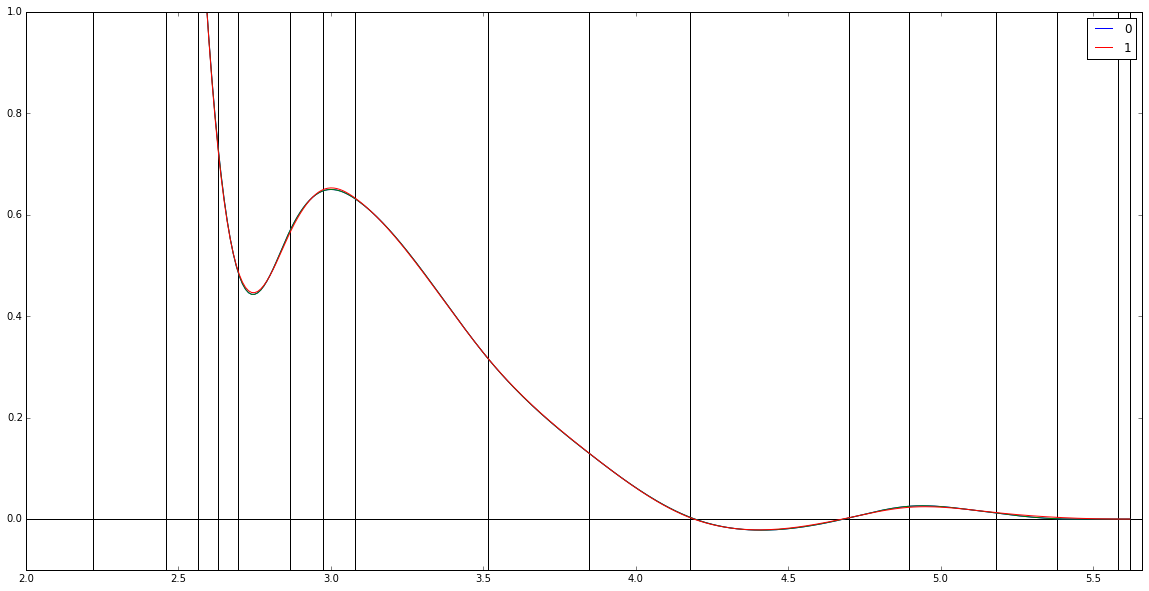

In [26]:
plt.figure(figsize=(20,10))
for i, para in enumerate(param_list[-2:]):
    knots_pairx = list(para['hyperparams']['pair'])
    coeff_pairx = list(para['params']['pair'])
    knots_edens = params['hyperparams']['edens']
    coeff_edens = params['params']['edens']
    embed = params['params']['embed']
    
    #rs = np.linspace(2, 5.82, 701)
    #rs = np.linspace(2.2, 5.66, 347)
    rs = np.linspace(2.2, 5.62, 343)


    y_pairx = [f_spline3(r, coeff_pairx, knots_pairx) for r in rs]
#    y_edens = [f_spline3(r, coeff_edens, knots_edens) for r in rs]

#     print(knots_pairx)
#     print(coeff_pairx)
#     print(knots_edens)
#     print(coeff_edens)
#     print(embed)
    
#    plt.scatter(params['hyperparams']['pair'], np.zeros(len(params['hyperparams']['pair'])))
    if i == 1:
        plt.vlines(para['hyperparams']['pair'], -10, 10)
        plt.plot(rs, y_pair)
#    plt.vlines(params['hyperparams']['edens'], -10, 10, colors='m')
    
    plt.plot(rs, y_pairx, '-', label=str(i))
#    plt.plot(rs, y_edens, '.', label=str(i))
    
    plt.xlim(2.0, 5.66)
    plt.ylim(-0.1,1)
    plt.hlines(xmin=2.0, xmax=6.0, y=0.0)

plt.legend()

In [20]:
with open(os.path.join(working, 'params_store' + '.pickle'), 'rb') as fi:
    model_params = pickle.load(fi)

In [21]:
model_params

[{'hyperparams': {u'edens': [2.5, 3.1000000000000001, 3.5, 4.9000000000000004],
   u'pair': [2.5648974999999998,
    2.6297950000000001,
    2.6946924999999999,
    2.8663175000000001,
    2.9730449999999999,
    3.0797724999999998,
    3.5164724999999999,
    3.8464450000000001,
    4.1764175000000003,
    4.7008450000000002,
    4.8952999999999998,
    5.0897550000000003,
    5.3429525,
    5.4016950000000001,
    5.4604375000000003]},
  'params': {'edens': array([-43.2896107 ,   4.64461212,   0.32332911,   0.05820618]),
   'embed': array([-4.18353755, -0.00963669]),
   'lrcorr': array([], dtype=float64),
   'pair': array([ -1.00171035e+02,   1.90025394e+01,   2.15938317e+01,
           -1.39759833e+01,   2.16332289e+01,  -3.29542126e+00,
            1.70455674e+00,   1.41347064e+00,  -9.02958785e-01,
           -8.62309098e-01,   1.95964588e+00,  -8.70527088e-01,
            3.22342700e-02,  -1.53866121e+00,   1.37095441e+00])}}]

In [ ]:
# fit function
def fit_spline
par_in = V_x_a
output = fmin(uloss, par_in, args=(r,), maxiter=100000, maxfun=100000, disp=0, full_output=1,ftol=1e-6)
pair_new = output[0]
print(*pair_new)

### Tungsten EAM IFF functions and parameters from Marinica et al. (corrected)

In [158]:
# Gauge conversion perameters
C = 1.848055990
S = 2.232322602e-1

# electronic density function (cubic splines)
rho = lambda r, a, k: sum([c*(p - r)**3 for c, p in zip(a, k) if r < p])

# embedding function
F = lambda d, a: a[0]*d**0.5 + a[1]*d + a[2]*d**2
F_new = lambda d, a: a[0]*d**0.5 + a[1]*d**2


Fc = lambda d, a: a[0] + a[1]*d + a[2]*d**2 + a[3]*d**3
Fe = lambda d, a: F(d/S, a) + C/S*d
Fa = lambda d, a1, a2: Fe(d, a1) if d < 1.359141225 else Fc(d, a2)

# pair potential function (same spline form as electronic density)
V = rho

In [159]:
# electronic density parameters
rho_re_a = [3.704045964e-3]
rho_re_r = [5.46]

# embeding function parameters
F_re_a = [-7.046791948, 1.23658472, 1.143405627]
#F_re_a = [-7.046791948, 0, 1.143405627]

# pair potential
V_re_a = [6.726805309, 3.217593889, -6.545857587e-1, 1.453229484e-1, -2.063629464e-1, 6.114909116e-2]
V_re_r = [2.7, 3.252, 3.804, 4.356, 4.908, 5.46]

In [160]:
def utot_re(x):
    u = 6*V(x, V_re_a, V_re_r)
    d = 12*rho(x, rho_re_a, rho_re_r)
    u += F(d, F_re_a)
    return u/12

def u_manybody_re(x):
    d = 12*rho(x, rho_re_a, rho_re_r)
    u = F(d, F_re_a)
    return u/12

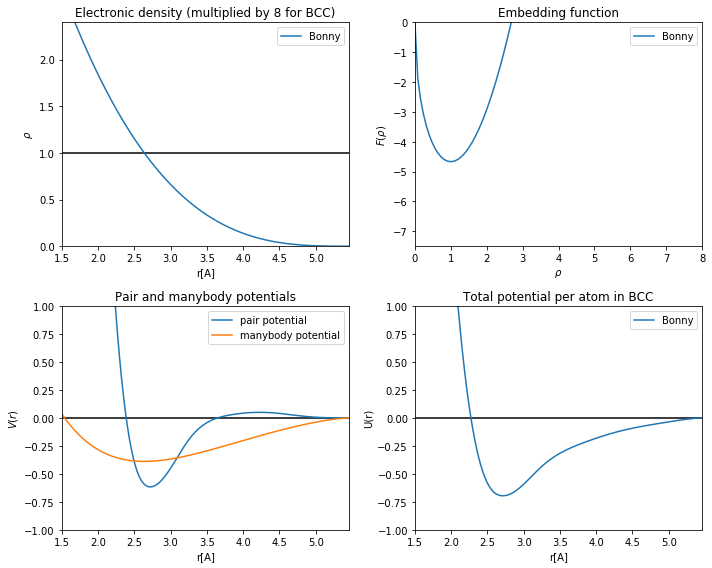

In [161]:
# plot the functions and potentials
rcut = 5.46
r = np.linspace(0., rcut, 201)

plt.figure(figsize=(10,8))

# Electronic density
dens = [rho(x, rho_re_a, rho_re_r)*12 for x in r]
plt.subplot(221)
plt.title('Electronic density (multiplied by 8 for BCC)')
plt.plot(r, dens, label='Bonny')
plt.legend()
plt.hlines(1.0, 1.5, rcut)
plt.axis([1.5, rcut, 0, 0.3*8])
plt.xlabel('r[A]')
plt.ylabel(r'$ \rho $')

# Embedding function
dens = np.linspace(0., 8., 101)
embed = [F(d, F_re_a) for d in dens]
plt.subplot(222)
plt.title('Embedding function')
plt.plot(dens, embed, label='Bonny')
plt.legend()
plt.axis([0, 8, -7.5, 0.0])
plt.xlabel(r'$\rho$')
plt.ylabel(r'$F(\rho)$')

# Pair and manybody potentials
pot = [V(x, V_re_a, V_re_r) for x in r]
pot_manybody = [u_manybody_re(x) for x in r]
plt.subplot(223)
plt.title('Pair and manybody potentials')
plt.plot(r, pot, label='pair potential')
plt.plot(r, pot_manybody, label='manybody potential')
plt.legend()
plt.hlines(0.0, 1.5, rcut)
plt.axis([1.5, rcut, -1.0, 1.0])
plt.xlabel('r[A]')
plt.ylabel(r'$V(r)$')

# Total potential per atom (bulk)
pot = [utot_re(x) for x in r]
plt.subplot(224)
plt.title('Total potential per atom in BCC')
plt.plot(r, pot, label='Bonny')
plt.legend()
plt.hlines(0.0, 1.5, rcut)
plt.axis([1.5, rcut, -1, 1.0])
plt.xlabel('r[A]')
plt.ylabel(r'U(r)')

plt.tight_layout()

In [209]:
# electronic density parameters
rho_x_a = [1.0]
rho_x_r = [5.48]

# embeding function parameters
#F_re_a = [-7.046791948, 0, 1.143405627]
#F_x_a = [-7.046791948, 1.23658472, 1.143405627]
F_x_a = [-7.046791948, 0.0, 1.143405627]



#3.704045964e-3

# pair potential
V_x_a = [x*2 for x in V_re_a][:]
#V_x_r = [2.74, 3.25, 3.75, 4.5, 5.48]
#V_x_r = [2.75, 3.25, 3.75, 4.356, 5.0, 5.5]
V_x_r = [2.5, 2.75, 3.25, 3.75, 4.25, 4.75, 5.25, 5.75]

V_x_a += [0.0, 0.0]
V_x_a

[13.453610618,
 6.435187778,
 -1.3091715174,
 0.2906458968,
 -0.4127258928,
 0.12229818232,
 0.0,
 0.0]

In [210]:
def utot_re(x):
    u = 6*V(x, V_re_a, V_re_r)
    d = 12*rho(x, rho_re_a, rho_re_r)
    u += F(d, F_re_a)
    return u/12

def u_manybody_re(x):
    d = 12*rho(x, rho_re_a, rho_re_r)
    u = F(d, F_re_a)
    return u/12


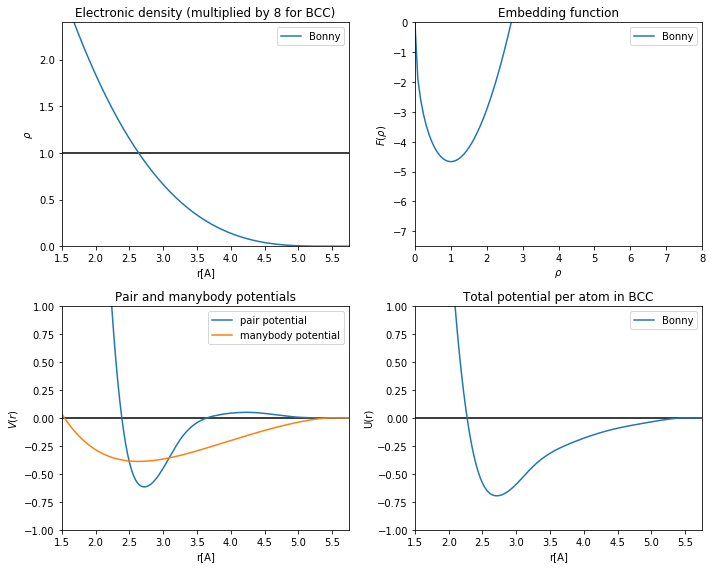

In [211]:
# plot the functions and potentials
rcut = 5.75
r = np.linspace(0., rcut, 201)

plt.figure(figsize=(10,8))

# Electronic density
dens = [rho(x, rho_re_a, rho_re_r)*12 for x in r]
plt.subplot(221)
plt.title('Electronic density (multiplied by 8 for BCC)')
plt.plot(r, dens, label='Bonny')
plt.legend()
plt.hlines(1.0, 1.5, rcut)
plt.axis([1.5, rcut, 0, 0.3*8])
plt.xlabel('r[A]')
plt.ylabel(r'$ \rho $')

# Embedding function
dens = np.linspace(0., 8., 101)
embed = [F(d, F_re_a) for d in dens]
plt.subplot(222)
plt.title('Embedding function')
plt.plot(dens, embed, label='Bonny')
plt.legend()
plt.axis([0, 8, -7.5, 0.0])
plt.xlabel(r'$\rho$')
plt.ylabel(r'$F(\rho)$')

# Pair and manybody potentials
pot = [V(x, V_re_a, V_re_r) for x in r]
pot_manybody = [u_manybody_re(x) for x in r]
plt.subplot(223)
plt.title('Pair and manybody potentials')
plt.plot(r, pot, label='pair potential')
plt.plot(r, pot_manybody, label='manybody potential')
plt.legend()
plt.hlines(0.0, 1.5, rcut)
plt.axis([1.5, rcut, -1.0, 1.0])
plt.xlabel('r[A]')
plt.ylabel(r'$V(r)$')

# Total potential per atom (bulk)
pot = [utot_re(x) for x in r]
plt.subplot(224)
plt.title('Total potential per atom in BCC')
plt.plot(r, pot, label='Bonny')
plt.legend()
plt.hlines(0.0, 1.5, rcut)
plt.axis([1.5, rcut, -1, 1.0])
plt.xlabel('r[A]')
plt.ylabel(r'U(r)')

plt.tight_layout()

In [212]:
# fit pair potential
def udif(p, r):
    uref = [V(x, V_re_a, V_re_r) for x in r]
    utry = [V(x, p, V_x_r) for x in r]
    return uref, utry

def uloss(p, r):
    uref = [V(x, V_re_a, V_re_r) for x in r]
    utry = [V(x, p, V_x_r) for x in r]
    loss = sum([(a-b)**2 for a, b in zip(uref, utry)])
    return loss

In [213]:
par_in = V_x_a
output = fmin(uloss, par_in, args=(r,), maxiter=100000, maxfun=100000, disp=0, full_output=1,ftol=1e-6)
pair_new = output[0]
print(*pair_new)

0.4527535290774057 7.091857873610367 1.6314949612839302 0.7906877956550405 -0.8249673243680319 0.14501087706040938 -0.002061634677032549 0.0021894588902290147


Text(0,0.5,'$V(r)$')

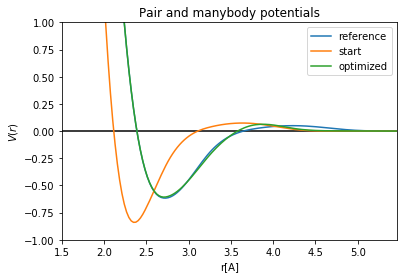

In [214]:
rcut = 5.46
r = np.linspace(0., rcut, 201)

uref, utry = udif(V_x_a, r)
uref, uopt = udif(pair_new, r)

plt.title('Pair and manybody potentials')
plt.plot(r, uref, label='reference')
plt.plot(r, utry, label='start')
plt.plot(r, uopt, label='optimized')

plt.legend()
plt.hlines(0.0, 1.5, rcut)
plt.axis([1.5, rcut, -1.0, 1.0])
plt.xlabel('r[A]')
plt.ylabel(r'$V(r)$')

In [215]:
# fit manybody potential
def u_manybody_dif(p, r):
    uref = [F(12*rho(x, rho_re_a, rho_re_r), F_re_a)/12 for x in r]
    utry = [F_new(12*rho(x, rho_x_a, rho_x_r), p)/12 for x in r]
    return uref, utry

def u_manybody_loss(p, r):
    uref = [F(12*rho(x, rho_re_a, rho_re_r), F_re_a)/12 for x in r]
    utry = [F_new(12*rho(x, rho_x_a, rho_x_r), p)/12 for x in r]
    loss = sum([(a-b)**2 for a, b in zip(uref, utry)])
    return loss

In [216]:
rho_x_a = [1.0]
r = np.linspace(0., rcut, 201)
par_in = [F_re_a[0], F_re_a[2]]
output = fmin(u_manybody_loss, par_in, args=(r,), maxiter=100000, maxfun=100000, disp=0, full_output=1,ftol=1e-6)
many_new = output[0]
print(*many_new)

-0.344540412587315 1.6869558429105695e-05


[-7.046791948, 1.23658472, 1.143405627]


Text(0,0.5,'$V(r)$')

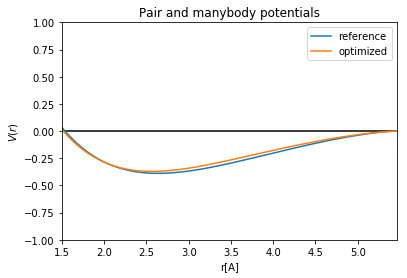

In [217]:
rcut = 5.46
r = np.linspace(0., rcut, 201)
print(F_re_a)
uref, utry = u_manybody_dif(F_re_a, r)
uref, uopt = u_manybody_dif(many_new, r)

plt.title('Pair and manybody potentials')
plt.plot(r, uref, label='reference')
#plt.plot(r, utry, label='start')
plt.plot(r, uopt, label='optimized')

plt.legend()
plt.hlines(0.0, 1.5, rcut)
plt.axis([1.5, rcut, -1.0, 1.0])
plt.xlabel('r[A]')
plt.ylabel(r'$V(r)$')

In [218]:
many_x = list(many_new)
pair_x = list(pair_new)

In [219]:
print(many_x + pair_x)

[-0.344540412587315, 1.6869558429105695e-05, 0.4527535290774057, 7.091857873610367, 1.6314949612839302, 0.7906877956550405, -0.8249673243680319, 0.14501087706040938, -0.002061634677032549, 0.0021894588902290147]


In [220]:
pars_in = {'pair':pair_x, 'embed':many_x}
with open('../data/working/pars_in.pickle', 'wb') as fo:
    pickle.dump(pars_in, fo)

In [188]:
def utot_opt(x, pn, mn):
    u = 6*V(x, pn, V_x_r)
    d = 12*rho(x, rho_x_a, rho_x_r)
    u += F_new(d, mn)
    return u/12

Text(0,0.5,'U(r)')

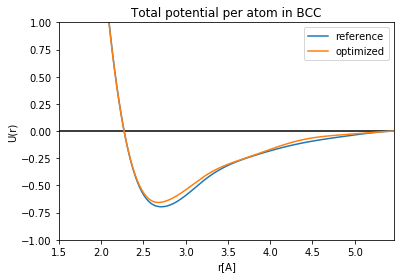

In [189]:
pot = [utot_re(x) for x in r]
pot_new = [utot_opt(x, pair_new, many_new) for x in r]

plt.title('Total potential per atom in BCC')
plt.plot(r, pot, label='reference')
plt.plot(r, pot_new, label='optimized')
plt.legend()
plt.hlines(0.0, 1.5, rcut)
plt.axis([1.5, rcut, -1, 1.0])
plt.xlabel('r[A]')
plt.ylabel(r'U(r)')

In [190]:
# modified functions
many_x = [x for x in many_new]
many_x[1] = 0.0

pair_x = [x for x in pair_new]
pair_x[-1] += 2*many_new[1]

In [191]:
print(pair_x)
print(many_x)

[7.262799609949834, 2.8551814788414784, -1.1750824011719558, 0.5925315310384949, -0.41006381316375573, 0.11876321014440062]
[-0.344540412587315, 0.0]


In [120]:
pair_new

array([ 0.83073149,  6.3064633 ,  2.56944634, -0.21327208, -0.2225459 ,
        0.02275643])

In [121]:
many_new

array([-4.09342761e-01,  3.54237104e-03,  1.53203715e-05])

In [96]:
many_x = [many_x[0], 0.0, 0.0]

Text(0,0.5,'U(r)')

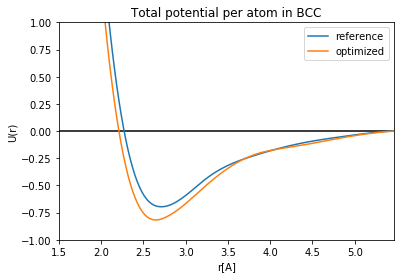

In [97]:
pot = [utot_re(x) for x in r]
pot_new = [utot_opt(x, pair_x, many_x) for x in r]

plt.title('Total potential per atom in BCC')
plt.plot(r, pot, label='reference')
plt.plot(r, pot_new, label='optimized')
plt.legend()
plt.hlines(0.0, 1.5, rcut)
plt.axis([1.5, rcut, -1, 1.0])
plt.xlabel('r[A]')
plt.ylabel(r'U(r)')

In [79]:
print('pair potentail parameters:', *pair_x)
print('embedding function parameters:', *many_x)

pair potentail parameters: 0.8307314918975489 6.306463298847209 2.569446338927059 -0.21327208205268988 -0.22254590199235236 0.02984117320348275
embedding function parameters: -0.4093427610992626 0.0 0.0


In [202]:
pwd

'/Users/l2v/work/force_fields/eam-models/notebooks'

In [22]:
%%writefile ../reports/parameters

Pair potential 
-1.00171035e+02,
1.90025394e+01,
2.15938317e+01,
-1.39759833e+01,
2.16332289e+01,
-3.29542126e+00,
1.70455674e+00,
1.41347064e+00,
-9.02958785e-01,
-8.62309098e-01,
1.95964588e+00,
-8.70527088e-01,
3.22342700e-02,
-1.53866121e+00,
1.37095441e+00,

(1,  0.960851701343041e2, 2.5648975),
(2, -0.184410923895214e3, 2.6297950),
(3,  0.935784079613550e2, 2.6946925),
(4, -0.798358265041677e1, 2.8663175),
(5,  0.747034092936229e1, 2.9730450),
(6, -0.152756043708453e1, 3.0797725),
(7,  0.125205932634393e1, 3.5164725),
(8,  0.163082162159425e1, 3.8464450),
(9, -0.141854775352260e1, 4.1764175),
(10,-0.819936046256149e0, 4.7008450),
(11, 0.198013514305908e1, 4.8953000),
(12,-0.696430179520267e0, 5.0897550),
(13, 0.304546909722160e-1,5.3429525),
(14,-0.163131143161660e1, 5.4016950),
(15, 0.138409896486177e1, 5.4604375)


Electronic density function
-4.32896107e+01,
4.64461212e+00,
3.23329113e-01,
5.82061842e-02,

[2.5, 3.1, 3.5, 4.9]

Embedding function parameters:
a_1^F: -4.18353755e+00
a_2^F: -9.63668936e-03

Writing ../reports/parameters


In [2]:
%load_ext rpy2.ipython

ModuleNotFoundError: No module named 'rpy2'

In [1]:
%%R

tpower <- function(x, t, p){
# Truncated p-th power function
(x - t) ^ p * (x > t)
}

bbase <- function(x, xl, xr, ndx, deg){
    # Construct a B-spline basis of degree 'deg'
    dx <- (xr - xl) / ndx
    knots <- seq(xl - deg * dx, xr + deg * dx, by = dx)

    P <- outer(x, knots, tpower, deg)
    n <- dim(P)[2]
    D <- diff(diag(n), diff = deg + 1) / (gamma(deg + 1) * dx ^ deg)
    B <- (-1) ^ (deg + 1) * P %*% t(D)
    B
}
    

UsageError: Cell magic `%%R` not found.


In [12]:
def tpf(r, rc):
    return (rc-r)**3 if r < rc else 0.0

In [21]:
rr = np.linspace(0, 4)
rr

array([0.        , 0.08163265, 0.16326531, 0.24489796, 0.32653061,
       0.40816327, 0.48979592, 0.57142857, 0.65306122, 0.73469388,
       0.81632653, 0.89795918, 0.97959184, 1.06122449, 1.14285714,
       1.2244898 , 1.30612245, 1.3877551 , 1.46938776, 1.55102041,
       1.63265306, 1.71428571, 1.79591837, 1.87755102, 1.95918367,
       2.04081633, 2.12244898, 2.20408163, 2.28571429, 2.36734694,
       2.44897959, 2.53061224, 2.6122449 , 2.69387755, 2.7755102 ,
       2.85714286, 2.93877551, 3.02040816, 3.10204082, 3.18367347,
       3.26530612, 3.34693878, 3.42857143, 3.51020408, 3.59183673,
       3.67346939, 3.75510204, 3.83673469, 3.91836735, 4.        ])

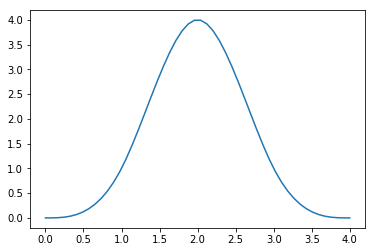

In [22]:
plt.plot(rr, [(tpf(r,0)-4*tpf(r,1)+6*tpf(r,2)-4*tpf(r,3)+tpf(r,4)) for r in rr])